![PyMC Labs](images/4-pymc-labs-transp-black.png)

# Session 2: PyMC and PyTensor

In this session, we'll explore the fundamental components that power PyMC: PyTensor and PyMC's variable classes. We'll learn how PyTensor defines and optimizes computational graphs, and how PyMC uses these capabilities to build probabilistic models.

## PyTensor Basics

PyTensor is the computational backend for PyMC. It defines symbolic variables and operations on them, which are compiled into efficient functions that can run on CPUs or GPUs. Let's begin by exploring the basic elements of PyTensor.

In PyTensor, you define a computational graph explicitly. You start with input variables that are essentially placeholders and from these, you build more intermediate variables by applying operators. These intermediate variables can then be treated as outputs or as inputs for further computation.

While PyTensor is designed to feel similar to NumPy to ease the learning curve, it's important to remember they are distinct. PyTensor operations build a graph of computations rather than executing them immediately like NumPy.

### Tensors and Basic Operations

To begin, let's define some PyTensor tensors and show how to perform some basic operations.

A tensor can be a scalar or a vector with any number of dimensions. 

Concretely:

In [8]:
import pytensor
import pytensor.tensor as pt
import numpy as np

x = pt.tensor(shape=(), dtype="float64")
y = pt.tensor(shape=(2,), dtype="float64")

print(
    f"""
x type: {x.type}
x shape = {x.type.shape}
---
y type: {y.type}
y shape = {y.type.shape}
"""
)


x type: Scalar(float64, shape=())
x shape = ()
---
y type: Vector(float64, shape=(2,))
y shape = (2,)



Now that we have defined the `x` and `y` tensors, we can create a new one by adding them together.

In [9]:
z = x + y
z.name = "x + y"
z

x + y

To make the computation a bit more complex let's take the logarithm of the resulting tensor.

In [10]:
w = pt.log(z)
w, type(w)

(Log.0, pytensor.tensor.variable.TensorVariable)

We did not give `w` a name, so it prints something more descriptive: its the index-0 output of calling the `log` function. Its type is `TensorVariable`, which is the base class for all PyTensor variables.

So PyTensor works something like NumPy, but it builds a graph of operations rather than executing, more like a symbolic computation library.

We can use the `pytensor.dprint` function to print the computational graph of any given tensor.

In [11]:
pytensor.dprint(w)

Log [id A]
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ <Scalar(float64, shape=())> [id D]
    └─ <Vector(float64, shape=(2,))> [id E]


Log [id A]
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ <Scalar(float64, shape=())> [id D]
    └─ <Vector(float64, shape=(2,))> [id E]


This output shows the structure of the computation that PyTensor has built for the variable `w`. Think of it as a recipe (in reverse):

*   **`Log [id A] 'log(x + y)'`**: This is the final result, `w`. It's calculated by taking the logarithm (`Log`) of an intermediate value named `'log(x + y)'`. PyTensor assigns it an internal identifier `A`.
*   **`Add [id B] 'x + y'`**: This is the input to the `Log` operation. It's an intermediate value named `'x + y'` (which we called `z` in the code), calculated by an addition (`Add`). Its internal ID is `B`.
*   **`ExpandDims{axis=0} [id C]`**: This is the first input to the `Add` operation. `ExpandDims` is an operation that changes the shape of a tensor. Here, it's likely making the scalar `x` compatible for addition with the vector `y`. Its ID is `C`.
    *   **`<Scalar(float64, shape=())> [id D]`**: This is the input to `ExpandDims`. It's our original scalar tensor `x` (ID `D`), which holds a single 64-bit floating-point number.
*   **`<Vector(float64, shape=(3,))> [id E]`**: This is the second input to the `Add` operation. It's our original vector tensor `y` (ID `E`), which holds three 64-bit floating-point numbers.

### Functions

Note that this graph does not do any computation (yet!). It is simply defining the sequence of steps to be done. We can use `pytensor.function` to define a callable object so that we can push values through the graph.

PyTensor functions are compiled from symbolic expressions into efficient callable functions. The `pytensor.function` constructor takes several key arguments that define how the function will behave:

- The `inputs` argument specifies which PyTensor variables will be provided when calling the function. These become the function's parameters.

- The `outputs` argument defines which symbolic expressions should be evaluated and returned when the function is called.

In [12]:
f = pytensor.function(inputs=[x, y], outputs=w)

Now that the graph is compiled, we can push some concrete values:

In [13]:
f(0, [1, np.e])

array([0., 1.])

> TIP:
> Sometimes we just want to debug, we can use `pytensor.graph.basic.Variable.eval` for that:

In [14]:
w.eval({x: 0, y: [1, np.e]})

array([0., 1.])

You can set intermediate values as well

In [ ]:
w.eval({z: [1, np.e]})

array([0., 1.])

### Graph Optimization

One of the most important features of `pytensor` is that it can automatically **optimize** the mathematical operations inside a graph. Let's consider a simple example:

In [ ]:
a = pt.tensor(shape=(), name="a")
b = pt.tensor(shape=(), name="b")

c = a / b
c.name = "a / b"

pytensor.dprint(c)

True_div [id A] 'a / b'
 ├─ a [id B]
 └─ b [id C]


Now let's multiply `b` times `c`. This should result in simply `a`.

In [10]:
d = b * c
d.name = "b * c"

pytensor.dprint(d)

Mul [id A] 'b * c'
 ├─ b [id B]
 └─ True_div [id C] 'a / b'
    ├─ a [id D]
    └─ b [id B]


The graph shows the full computation, but once we compile it the operation becomes the identity on `a` as expected.

In [11]:
g = pytensor.function(inputs=[a, b], outputs=d)

pytensor.dprint(g)

DeepCopyOp [id A] 0
 └─ a [id B]


### What is in a PyTensor Graph?

The following diagram shows the basic structure of an `pytensor` graph.

![pytensor graph](images/apply.png)

We can make these concepts more tangible by explicitly indicating them in our earlier example. Let's compute the graph components for the tensor `z`.

In [12]:
print(
    f"""
z type: {z.type}
z name = {z.name}
z owner = {z.owner}
z owner inputs = {z.owner.inputs}
z owner op = {z.owner.op}
z owner output = {z.owner.outputs}
"""
)


z type: Vector(float64, shape=(?,))
z name = x + y
z owner = Add(ExpandDims{axis=0}.0, y)
z owner inputs = [ExpandDims{axis=0}.0, y]
z owner op = Add
z owner output = [x + y]



### Graph Manipulation

Another interesting feature of PyTensor is the ability to manipulate the computational graph, something that is not possible with TensorFlow or PyTorch. Here we'll see how to modify an existing graph.

In [13]:
# get input tensors
list(pytensor.graph.graph_inputs(graphs=[w]))

[x, y]

As a simple example, let's add an `pytensor.tensor.exp` before the `pytensor.tensor.log` (to get the identity function).

In [14]:
parent_of_w = w.owner.inputs[0]  # get z tensor
new_parent_of_w = pt.exp(parent_of_w)  # modify the parent of w
new_parent_of_w.name = "exp(x + y)"

Note that the graph of `w` has actually not changed:

In [15]:
pytensor.dprint(w)

Log [id A] 'log(x + y)'
 └─ Add [id B] 'x + y'
    ├─ ExpandDims{axis=0} [id C]
    │  └─ x [id D]
    └─ y [id E]


To modify the graph we need to use the `pytensor.clone_replace` function, which *returns a copy of the initial subgraph with the corresponding substitutions.*

In [16]:
new_w = pytensor.clone_replace(output=[w], replace={parent_of_w: new_parent_of_w})[0]
new_w.name = "log(exp(x + y))"
pytensor.dprint(new_w)

Log [id A] 'log(exp(x + y))'
 └─ Exp [id B] 'exp(x + y)'
    └─ Add [id C] 'x + y'
       ├─ ExpandDims{axis=0} [id D]
       │  └─ x [id E]
       └─ y [id F]


Finally, we can test the modified graph by passing some input to the new graph.

In [17]:
new_w.eval({x: 0, y: [1, np.e]})

array([1.        , 2.71828183])

As expected, the new graph is just the identity function.

> NOTE:
> Again, note that `pytensor` is clever enough to omit the `exp` and `log` once we compile the function.

In [18]:
f = pytensor.function(inputs=[x, y], outputs=new_w)

pytensor.dprint(f)

Add [id A] 'x + y' 1
 ├─ ExpandDims{axis=0} [id B] 0
 │  └─ x [id C]
 └─ y [id D]


In [ ]:
f(0, [1, np.e])

array([1.        , 2.71828183])

### Example: Logistic Regression

Here is a non-trivial example, which uses PyTensor to estimate the parameters of a logistic regression model using a simple version of gradient descent. We will use a bioassay example as a test case.

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to `n=5` rats during the experiment. The response variable is `death`, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
\text{logit}(p_i) &= a + b x_i \\
y_i &\sim \text{Bin}(n_i, p_i) \\
\end{aligned}$$

The common statistic of interest in such experiments is the **LD50**, the dosage at which the probability of death is 50%.

In [ ]:
import numpy as np

rng = np.random

dose = np.array([-0.86, -0.3 , -0.05,  0.73])
n = 5
deaths = np.array([0, 1, 3, 5])

First, let's declare our symbolic variables.

In [53]:
X = pt.tensor("X", shape=(None,))
Y = pt.tensor("Y", shape=(None,))
a = pt.tensor("a", shape=())
b = pt.tensor("b", shape=())

... then construct the expression graph:

In [54]:
# Probability that target = 1
p_1 = 1 / (1 + pt.exp(-(a +X*b))) 
p_1.name = "prob_target_1"

# The prediction threshold
prediction = p_1 > 0.5         

# Cross-entropy loss function
xent = -Y * pt.log(p_1) - (n-Y) * pt.log(1-p_1) 
xent.name = "cross-entropy"

# The cost to minimize
cost = xent.mean()      

# Compute the gradient of the cost
ga, gb = pt.grad(cost, [a, b])  

# Learning rate
step = pt.tensor('step', shape=())

# Update the parameters
a_new = a - step * ga
b_new = b - step * gb
step_new = step * 0.99

Recall that in order to use these expressions, we need to compile them into functions.

Below we compile two functions: `train()` which performs gradient descent by updating parameters based on input data, and `predict()` which makes predictions using the current parameter values. 

In [55]:
train = pytensor.function(
          inputs=[X, Y, a, b, step],
          outputs=[prediction, xent, a_new, b_new, step_new],
)
predict = pytensor.function(inputs=[X, a, b], outputs=prediction)

Now we can train the model.

In [ ]:
alpha, beta, lr = 0., 1., 10.
training_steps = 1000
for i in range(training_steps):
    pred, err, alpha, beta, lr = train(dose, deaths, alpha, beta, lr)
    
print("Final model:", alpha, beta)

Final model: 0.8536420249683847 7.795152457538434


In [ ]:
def logit(x): 
    return 1. / (1 + np.exp(-x))
    
xvals = np.linspace(-1, 1)

go.Figure().add_trace(go.Scatter(
    x=xvals, 
    y=logit(beta*xvals + alpha),
    mode='lines',
    name='Fitted Model'
)).add_trace(go.Scatter(
    x=dose, 
    y=[d/n for d in deaths],
    mode='markers',
    marker=dict(color='red', size=10),
    name='Observed Data'
)).update_layout(
    title='Logistic Regression Model',
    xaxis_title='Log Dose',
    yaxis_title='Probability of Death',
    width=600
).show()

ADD STABILIZATION AND CANONICALIZATION REWRITES(?)

## PyMC Variable Classes

Bayesian inference begins with specification of a probability model relating unknown variables to data. PyMC provides the basic building blocks for Bayesian probability models: stochastic random variables, deterministic variables, and factor potentials. 

A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. The third quantity, the **factor potential**, is *not* a variable but simply a
log-likelihood term or constraint that is added to the joint log-probability to modify it.

### The Distribution Class

A stochastic variable is represented in PyMC by a `Distribution` class. This structure adds functionality to Pytensor's `pytensor.tensor.random.op.RandomVariable` class, mainly by registering it with an associated PyMC `Model` -- so `Distribution` objects are only usable inside of a `Model` context.

`Distribution` subclasses (i.e. implementations of specific statistical distributions) will accept several arguments when constructed:

`name`
:   Name for the new model variable. This argument is **required**, and is used as a label and index value for the variable.

`model`
:   The PyMC model to which the variable belongs.

`shape`
:   The variable's shape.

`total_size`
:   The overall size of the variable (this variable will not exist for scalars).

`dims`
:   A tuple of dimension names known to the model.

`transform`
:   A transformation to be applied to the distribution when used by the model, especially when the distribution is constrained.

`initval`
:   Numeric or symbolic untransformed initial value of matching shape, or one of the following initial value strategies: "moment", "prior". Depending on the sampler's settings, a random jitter may be added to numeric, symbolic or moment-based initial values in the transformed space.


Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. For this purpose, `Distribution` objects have a method `dist` that returns a **stateless** probability distribution of that type; that is, without being wrapped in a PyMC random variable object. 

In [26]:
import pymc as pm
import plotly.express as px

x = pm.Exponential.dist(1)
samples = pm.draw(x, draws=1000)
fig = px.histogram(samples, title="Exponential Distribution Samples")
fig.update_layout(xaxis_title="Value", yaxis_title="Count", showlegend=False)
fig.show();

### Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents.

There are two types of deterministic variables in PyMC:

**Anonymous deterministic variables**

The easiest way to create a deterministic variable is to operate on or transform one or more variables in a model directly. For example:

```python
with pm.Model() as model:
    x = pm.Normal('x', 0, 1)
    y = pm.Normal('y', 0, 1)
    z = x + y  # This is an anonymous deterministic variable
```

These are called *anonymous* variables because we did not wrap it with a call to `Determinstic`, which gives it a name as its first argument. We simply specified the variable as a Python (or, PyTensor) expression. This is therefore the simplest way to construct a determinstic variable. The only caveat is that the values generated by anonymous determinstics at every iteration of a MCMC algorithm, for example, are not recorded to the resulting trace. So, this approach is only appropriate for intermediate values in your model that you do not wish to obtain posterior estimates for, alongside the other variables in the model.

**Named deterministic variables**

To ensure that deterministic variables' values are accumulated during sampling, they should be instantiated using the named deterministic interface; this uses the `Deterministic` function to create the variable. Two things happen when a variable is created this way:

1. The variable is given a name (passed as the first argument)
2. The variable is appended to the model's list of random variables, which ensures that its values are tallied.

For example:

```python
with pm.Model() as model:
    x = pm.Normal('x', 0, 1)
    y = pm.Normal('y', 0, 1)
    z = pm.Deterministic('z', x + y)  # This is a named deterministic variable
```

### Observed Random Variables

Stochastic random variables whose values are observed are represented by a different class than unobserved random variables. An `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. For example:

```python
with pm.Model() as model:
    x = pm.Normal('x', 0, 1)
    y = pm.Normal('y', x, 1, observed=[0.1, 0.2, 0.3])
```

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, if there are any.

### Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents. For example, suppose in the IQ drug model we want to constrain the difference between the placebo and drug means to be less than 10, so that the joint density becomes: 

$$p(y,\nu,\mu_1,\mu_2, \sigma_1, \sigma_2) \propto p(y|\nu,\mu_1,\mu_2, \sigma_1, \sigma_2) p(\nu) p(\mu_1) p(\mu_2) p(\sigma_1) p(\sigma_2) I(|\mu_2-\mu_1| \lt 10)$$

We call such log-probability terms **factor potentials** (Jordan 2004).

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface:

```python
with disaster_model:
    
    diff_constraint = pm.Potential('diff_constraint', pm.math.switch(pm.math.abs(treat_mean-placebo_mean)>10, -np.inf, 0))
```

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

A common use of a factor potential is to represent an observed likelihood, where the **observations are partly a function of model variables**. In the contrived example below, we are representing the error in a linear regression model as a zero-mean normal random variable. Thus, the "data" in this scenario is the residual, which is a function both of the data and the regression parameters. 

If we represent this as a standard likelihood function (a `Distribution` with an `observed` keyword argument), we run into problems. This parameterization would not be compatible with an observed stochastic, because the `err` term would become fixed in the likelihood and not be allowed to change during sampling.

In [27]:
# TypeError expected

y_vals = np.array([15, 10, 16, 11, 9, 11, 10, 18, 11])
x_vals = np.array([1, 2, 4, 5, 6, 8, 19, 18, 12])

with pm.Model() as regression:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sigma=2)
    mu = pm.Normal('mu', 0, sigma=10)

    err = y_vals - (mu + beta*x_vals)
                  
    like = pm.Normal('like', 0, sigma=sigma, observed=err)

TypeError: Variables that depend on other nodes cannot be used for observed data.The data variable was: Sub.0

Instead, we can re-express the likelihood as a factor potential, which is a function of the data and the model parameters.

In [28]:
with pm.Model() as regression:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sigma=2)
    mu = pm.Normal('mu', 0, sigma=10)

    err = y_vals - (mu + beta*x_vals)
                  
    like = pm.Potential('like', 
        pm.logp(
            pm.Normal.dist(0, sigma=sigma), 
            err
        )
    )

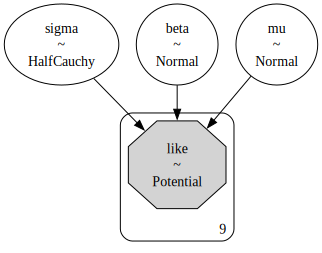

In [29]:
from pymc.model_graph import model_to_graphviz

model_to_graphviz(regression)

## Parameter Transformation

To support efficient sampling by PyMC's MCMC algorithms, any continuous variables that are constrained to a sub-interval of the real line are automatically transformed so that their support is unconstrained. This frees sampling algorithms from having to deal with boundary constraints.

For example, if we look at the variables we have created in a model:

In [30]:
with pm.Model() as model:
    sigma = pm.HalfNormal('sigma', 25)
    tau = pm.HalfStudentT('tau', 2, 10)
    lam = pm.HalfStudentT('lam', 5, 1)
    c2 = pm.InverseGamma('c2', 1, 0.1)
    print(model.value_vars)

[sigma_log__, tau_log__, lam_log__, c2_log__]


The model's `value_vars` attribute stores the values of each random variable actually used by the model's log-likelihood.

As the name suggests, the variables `sigma`, `tau`, `lam`, and `c2` have been log-transformed, and this is the space over which posterior sampling takes place. When a sample is drawn, the value of the transformed variable is simply back-transformed to recover the original variable.

By default, auto-transformed variables are ignored when summarizing and plotting model output, since they are not generally of interest to the user.

## Building Models in PyMC

Now that we understand the basic building blocks of PyMC models, let's see how to combine them to build a complete model. We'll use a real-world example of educational outcomes for hearing-impaired children.

### Educational Outcomes for Hearing-impaired Children

To demonstrate the PyMC API in depth, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes. 

This anonomized dataset is taken from the Listening and Spoken Language Data Repository (LSL-DR), an international data repository that tracks the demographics and longitudinal outcomes for children who have hearing loss and are enrolled in programs focused on supporting listening and spoken language development. Researchers are interested in discovering factors related to improvements in educational outcomes at these programs.

For each learner, the dataset includes these variables, which we will use as predictors: 

* gender (`male`)
* number of siblings in the household (`siblings`)
* index of family involvement (`family_inv`)
* whether the primary household language is not English (`non_english`)
* presence of a previous disability (`prev_disab`)
* non-white race (`non_white`)
* age at the time of testing (in months, `age_test`)
* whether hearing loss is not severe (`non_severe_hl`)
* whether the subject's mother obtained a high school diploma or better (`mother_hs`)
* whether the hearing impairment was identified by 3 months of age (`early_ident`).

The outcome variable we'll model is a standardized test score in one of several learning domains.

In [31]:
import polars as pl

test_scores = pl.read_csv(pm.get_data("test_scores.csv")).drop("")
test_scores.head()

score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
i64,i64,f64,f64,bool,f64,i64,f64,f64,bool,bool
40,0,2.0,2.0,false,null,55,1.0,null,false,false
31,1,0.0,null,false,0.0,53,0.0,0.0,false,false
83,1,1.0,1.0,true,0.0,52,1.0,null,false,true
75,0,3.0,null,false,0.0,55,0.0,1.0,false,false
62,0,0.0,4.0,false,1.0,50,0.0,null,false,false


In [32]:
test_scores["score"].plot.hist()

alt.Chart(...)

In [33]:
# Dropping missing values is not generally good practice, but we do so here for simplicity
test_scores = test_scores.drop_nulls().cast(pl.Float32)
y = test_scores["score"]
# Standardize the features
X = test_scores.drop("score").select((pl.all()-pl.all().mean()) / pl.all().std())

N, D = X.shape

### The Regression Model

This is a **multivariate regression** model, which takes the form:

$$\begin{aligned} 
\mu &= \beta_0 + X \beta \\
Y  &\sim \mathcal{N}(\mu, \sigma^2) \\
\end{aligned}$$

where $X$ is a matrix of predictors and $\beta$ a vector of coefficients.

Here's what that looks like in a PyMC model.

In [34]:
with pm.Model(coords={"predictors": X.columns}) as multiple_regression:
    
    # intercept centered at the population mean
    beta0 = pm.Normal("beta0", 100, 25)
    
    # priors for the coefficients
    beta = pm.Normal("beta", 0, 25, dims='predictors')
    
    # prior on error SD
    sigma = pm.HalfNormal("sigma", 25)
    
    # likelihood of the data given the betas and sigma
    scores = pm.Normal("scores", beta0 + X.to_numpy() @ beta, sigma, observed=y.to_numpy())

The first line takes advantage of **named dimensions** by passing the input variable names into the model as coordinates called "predictors". This will allow us to pass this vector of names as a replacement for the `shape` integer argument in the vector-valued parameters. The model will then associate the appropriate name with each latent parameter that it is estimating. This is a little more work to set up, but will pay dividends later when we are working with our model output.

The last line implements the regression model, using `to_numpy` to convert Pandas structures to NumPy arrays, which work with PyTensor.

Here's the graph representation of the model.

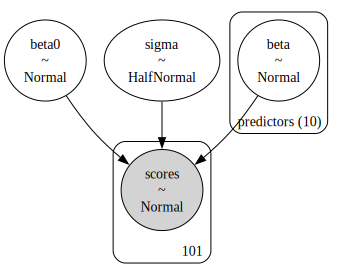

In [35]:
from pymc.model_graph import model_to_graphviz

model_to_graphviz(multiple_regression)

In this version of the model, the prior distributions for the coefficients contain an parameter that controls their width.
If this parameter is large, it leaves the coefficients uncontrained.
If we clamp it down, it keeps all of the coefficients small.
But unless we have legitimate prior information about the magnitudes of the coefficients, the choice of these parameters is arbitary.
And if we leave them unconstrained, the model is prone to overfitting.
This is the problem regularization is meant to solve.

### Regularization

There are several potential predictors in the LSL-DR dataset, but it is difficult *a priori* to determine which ones are relevant for constructing an effective statistical model. There are a number of approaches for conducting variable selection, but a popular automated method is *regularization*, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes. 

In machine learning or classical statistics, regularization methods like the lasso or ridge regression shrink parameters towards zero by applying a penalty to the size of the regression parameters. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the *hierarchical regularized horseshoe*, which uses regularization at two levels, a global shrinkage parameter, which determines the overall strength of regulatization across all coefficients, and local shrinkage parameter that determine the strength of regularization for each coefficient individually. 
The key to making this work is by selecting a long-tailed distribution as the prior for the shrinkage parameters, which allows some to be nonzero, while pushing the rest towards zero.

The prior for each regression coefficient $\beta_i$ looks like this:

$$\beta_i \sim N\left(0, \tau^2 \cdot \tilde{\lambda}_i^2\right)$$

where $\tau$ is the global shrinkage parameter and $\tilde{\lambda}_i$ is the local shrinkage parameter for the $i$th coefficient.
Their product is the standard deviation of the prior distribution of $\beta_i$, so if either of them is small, the product is small.

For the prior on $\tau$ we will use a Half-StudentT distribution, which is heavy-tailed -- the subscript $2$ is the parameter (called degrees of freedom) that controls the tail thickness of the $t$ distribution.

$$
\tau \sim \textrm{Half-StudentT}_{2} \left(\frac{D_0}{D - D_0} \cdot \frac{\sigma}{\sqrt{N}}\right).
$$

The parameter of the StudentT distribution is the variance of the regression errors, which depends on $\sigma$, which we will estimate from the data, and the sample size $N$.
As the sample size increases, the strength of regularization decreases.

The parameterization of the prior also depends on a pre-specified value $D_0$, which represents the true number of non-zero coefficients. Fortunately, a reasonable guess at this value is all that is required, and it need only be within an order of magnitude of the true number. Let's use half the number of predictors as our guess:

In [36]:
D0 = int(D / 2)
D0

5

Meanwhile, the local shrinkage parameters are defined by the ratio:

$$\tilde{\lambda}_i^2 = \frac{c^2 \lambda_i^2}{c^2 + \tau^2 \lambda_i^2}.$$

Where $\lambda_i$ is a raw shrinkage parameter and $\tilde{\lambda}_i$ is a scaled shrinkage parameter, and $c$ is the scaling parameter.

To complete the specification of this model, we need priors on $\lambda_i$ and $c$;  as with the global shrinkage, we use a long-tailed $\textrm{Half-StudentT}_5(1)$  on the $\lambda_i$. We need $c^2$ to be strictly positive, but not necessarily long-tailed, so an inverse gamma prior on $c^2$, $c^2 \sim \textrm{InverseGamma}(1, 1)$ fits the bill.

Let's build a model that incorporates regularization. First, we'll define the priors:

In [37]:
with pm.Model(coords={"predictors": X.columns}) as test_score_model:

    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)
    
    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)

Now we'll calculate the shrinkage standard deviation and the regression coefficients:

In [38]:
with test_score_model:
    # Calculate the shrinkage standard deviation (anonymous deterministic)
    shrinkage_sd = tau * lam * pm.math.sqrt(c2 / (c2 + tau**2 * lam**2))
    
    # Regularized regression coefficients
    beta = pm.Normal('beta', 0, shrinkage_sd, dims='predictors')
    
    # Intercept (not regularized)
    beta0 = pm.Normal("beta0", 100, 25)

Finally, we'll add the likelihood:

In [39]:
with test_score_model:
    # Likelihood
    scores = pm.Normal("scores", beta0 + X.to_numpy() @ beta, sigma, observed=y.to_numpy())

Now that the model is complete, let's see what the graph looks like.

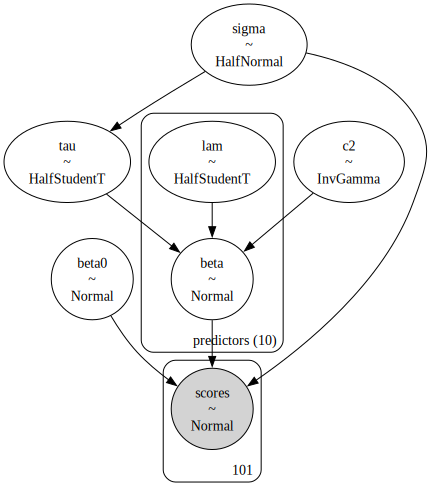

In [40]:
pm.model_to_graphviz(test_score_model)

## Exercise: Bioassay Model

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is death, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
\text{logit}(p_i) &= a + b x_i \\
y_i &\sim \text{Bin}(n_i, p_i) \\
\end{aligned}$$

The common statistic of interest in such experiments is the LD50, the dosage at which the probability of death is 50%.

Specify this model in PyMC:

In [41]:
# Log dose in each group
log_dose = [-.86, -.3, -.05, .73]

# Sample size in each group
n = 5

# Outcomes
deaths = [0, 1, 3, 5]

In [42]:
# Write your answer here
with pm.Model() as bioassay_model:
    # Priors for intercept and slope
    a = pm.Normal('a', 0, 5)
    b = pm.Normal('b', 0, 5)
    
    # Probability of death in logit-space
    logit_p = a + b * np.array(log_dose)
    
    # Convert from logit to probability
    p = pm.math.invlogit(logit_p)
    
    # Likelihood (binomial observations)
    y = pm.Binomial('y', n=n, p=p, observed=deaths)

---

## References

1. Ching & Chen. 2007. Transitional Markov chain Monte Carlo method for Bayesian model updating, model class selection and model averaging. Journal of Engineering Mechanics 2007
2.	Hoffman MD, Gelman A. 2014. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 15(1):1593-1623.
3. M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
4. Neal, R. M. 2003. Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198